# Clustering of VGG features

In [1]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
import time
# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
from skimage import io

from findmaxima2d import find_maxima
import tifffile
import glob

from PIL import Image
import sys
sys.path.append('../src')
from convert_ROI_to_cell_volumes import *

from scipy import ndimage
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from sklearn.manifold import TSNE
from PIL import Image
         
            
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


### TSNE and Kmeans prediction of images.

### Trains from image volumes (without time)

In [ ]:
outpaths = ['/Users/dominicwaithe/Desktop/special/']

#pca = pickle.load(open( "/Users/dominicwaithe/Desktop/cell_images/pca.pickle", "rb" ))
#kmeans = pickle.load(open( "/Users/dominicwaithe/Desktop/cell_images/kmeans.pickle", "rb" ))
channel = 1
cell_data = []

imgnum = 0
xs = []
store_cell_feats = []
for path in evalpaths:
    data,roi_array = collect_info(path,channel,'raw')
    
    for cell in range(0,data.__len__()):
        
        img_vol = data[cell]
        cell_shape = img_vol.__len__()
        raw_img = img_vol[cell_shape//2]
        nimg = normalise_for_8bit(raw_img)
        img = Image.fromarray(np.uint8(nimg))
        img = img.resize((224, 224), Image.ANTIALIAS)
        
        img = np.array(img)
        reshaped_img = np.zeros((1,224,224,3))
        reshaped_img[0,:,:,0] = img
        reshaped_img[0,:,:,1] = img
        reshaped_img[0,:,:,2] = img
        # prepare image for model
        imgx = preprocess_input(reshaped_img)
        # get the feature vector
        features = model.predict(imgx, use_multiprocessing=True)
        store_cell_feats.append(features)
        

feat = np.array(list(store_cell_feats))
feat = feat.reshape(-1,4096)
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=10, random_state=22)
pca.fit(feat)


#_TSNE = TSNE(n_components=2)
#x = _TSNE.fit_transform(feat)

#x = pca.transform(feat)

# cluster feature vectors
kmeans = KMeans(n_clusters=4,n_jobs=-1, random_state=22)
kmeans.fit(x)
x = pca.transform(feat)
xs.append(x)
cell_data.append(kmeans.predict(x))
copy_to_clipboard(cell_data)

In [ ]:

def copy_to_clipboard(cell_data):
    stg = ""
    maxt = 0
    for num in range(0,cell_data.__len__()):
        if cell_data[num].__len__() > maxt:
            maxt = cell_data[num].__len__()
    for idx in range(0,maxt):
        for num in range(0,cell_data.__len__()):
            if idx < cell_data[num].__len__():
                stg += str(cell_data[num][idx]) 
            stg+="\t"
        stg+='\n'
    pyperclip.copy(stg)
    spam = pyperclip.paste()

In [ ]:
x = xs[0]
labels = cell_data[0]
bint = labels==0
plt.plot(x[bint,0],x[bint,1],'x')
bint = labels==1
plt.plot(x[bint,0],x[bint,1],'bo')
bint = labels==2
plt.plot(x[bint,0],x[bint,1],'ko')
bint = labels==3
plt.plot(x[bint,0],x[bint,1],'+')

### Timeseries data
Train from timeseries. Pools all cellular images from dataset for clustering.

In [ ]:
#timeseries
#Train from timeseries. Pools all cellular images from dataset for clustering.

train_paths = ['/Users/dominicwaithe/Desktop/focused_stkoutMD2join_0016/']
channel = 0
cell_data = []

imgnum = 0
xs = []
cell_img = []
train_array_feats = []


for path in train_paths:
    data, roi_array = collect_info(path,channel,'raw')
    
    for cell in range(0,data.__len__()):
        
        img_vol = data[cell]
        cell_shape = img_vol.__len__()
       
        if cell_shape > 200:
            reshaped_img = np.zeros((cell_shape,224,224,3))
            for i, raw_img in enumerate(img_vol):
                t1 = time.time()
                nimg = normalise_for_8bit(raw_img)
                img = Image.fromarray(np.uint8(nimg))
                img = img.resize((224, 224), Image.NEAREST,reducing_gap=3)
                img = np.array(img)
                
                
                reshaped_img[i,:,:,0] = img
                reshaped_img[i,:,:,1] = img
                reshaped_img[i,:,:,2] = img
                cell_img.append(img)
                # prepare image for model
            imgx = preprocess_input(reshaped_img)
            t2 = time.time()
            # get the feature vector
            features = model.predict(imgx, use_multiprocessing=True)
            train_array_feats.extend(features)
            
            t3 = time.time()
            print('time',t2-t1,t3-t2)

feat = np.array(list(train_array_feats))
feat = feat.reshape(-1,4096)
pca = PCA(n_components=10, random_state=22)
pca.fit(feat)
x = pca.transform(feat)
xs.append(x)
kmeans = KMeans(n_clusters=3,n_jobs=-1, random_state=22)
kmeans.fit(x)

pickle.dump(pca,open( "pca_timeseries.pickle", "wb" ))
pickle.dump(kmeans,open( "kmeans_timeseries.pickle", "wb" ))

cell_data.append(kmeans.predict(x))

### Timeseries data
Evaluates timeseries.

In [ ]:
#timeseries
#Evaluate with 
eval_paths = ['/Users/dominicwaithe/Desktop/focused_stkoutMD2join_0012/']

pca = pickle.load(open( "pca_timeseries.pickle", "rb" ))
kmeans = pickle.load(open( "kmeans_timeseries.pickle", "rb" ))
channel = 0
cell_data = []

imgnum = 0
xs = []
cell_img = []
#flowers_sub.sort()
for path in eval_paths:
    data, roi_array = collect_info(path,channel,'raw')
    
    for cell in range(0,data.__len__()):
        
        store_cell_feats = []
        img_vol = data[cell]
        cell_shape = img_vol.__len__()
        
        if cell_shape > 200:
            reshaped_img = np.zeros((cell_shape,224,224,3))
            for i, raw_img in enumerate(img_vol):
                t1 = time.time()
                nimg = normalise_for_8bit(raw_img)
                img = Image.fromarray(np.uint8(nimg))
                img = img.resize((224, 224), Image.NEAREST,reducing_gap=3)
                img = np.array(img)
                
                
                reshaped_img[i,:,:,0] = img
                reshaped_img[i,:,:,1] = img
                reshaped_img[i,:,:,2] = img
                cell_img.append(img)
                # prepare image for model
            imgx = preprocess_input(reshaped_img)
            t2 = time.time()
            # get the feature vector
            features = model.predict(imgx, use_multiprocessing=True)
            store_cell_feats.extend(features)
            
            t3 = time.time()
            print('time',t2-t1,t3-t2)
        if store_cell_feats.__len__()>0:
            feat = np.array(list(store_cell_feats))
            feat = feat.reshape(-1,4096)
            x = pca.transform(feat)
            xs.append(x)
            cell_data.append(kmeans.predict(x))


### Visualises clustering.
Train from timeseries. Pools all cellular images from dataset for clustering.

In [ ]:
#from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
for dc in range(0,xs.__len__()):
    i =0
    dim0 = 0
    dim1 = 1
    #dc = 2
   
    
    if xs[dc].__len__() >15:
        #fig = plt.figure()
        #plt.ylim(-30,30)
        #plt.xlim(-60,60)
        #ax  = Axes3D(fig)


        for xy,clu in zip(xs[dc],cell_data[dc]):
            b = [xy[dim0],xy[dim1]]
           
            if clu == 0:
                
                #ax.scatter(b[0], b[1], i,marker='o',color='c')
                #.plot(b[0],i,'cx')
                plt.plot(dc,i,'yx')
                #plt.plot(b[0],b[1],'co',alpha=0.2)
                pass
            if clu == 1:
                #ax.scatter(b[0], b[1], i,marker='o',color='b')
                #plt.plot(b[0],i,'bo')
                plt.plot(dc,i,'bo')
                #plt.plot(b[0],b[1],'bo',alpha=0.2)
                pass
            if clu == 2:
                #ax.scatter(b[0], b[1], i,marker='o',color='k')
                #plt.plot(b[0],i,'ko')
                plt.plot(dc,i,'ko')
                #plt.plot(b[0],b[1],'ko',alpha=0.2)
                pass
            if clu == 3:
                
                #ax.scatter(b[0], b[1], i,marker='o',color='y')
                #plt.plot(b[0],i,'yo')
                plt.plot(dc,i,'yo')
                
                #plt.plot(b[0],b[1],'yo',alpha=0.2)
                pass
            #if i >0:
                #rgb = np.array([np.random.random(),np.random.random(),np.random.random()])#
                #rgb = (1-(float(i)/float(256)))
                #ax.plot3D([c[0],b[0]], [c[1],b[1]], [i-1,i], color=rgb )# Data for three-dimensional scattered points

                
                #if np.sqrt((b[0]-c[0])**2+ (b[1]-c[1])**2) <20:
                #plt.arrow(c[0],c[1],b[0]-c[0],b[1]-c[1],color=[rgb,rgb,rgb],width=0.1,alpha=1)
            c = b
            i +=1/6


In [2]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cell_data,cell_img,cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    indices  = np.where(np.array(cell_data) == cluster)[0]
    np.random.shuffle(indices)
    
    files = np.array(cell_img)[indices]
    # only allow up to 30 images to be shown at a time
    if len(files) > 100:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:99]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        
        img = np.array(file)
        plt.imshow(img)
        plt.axis('off')


In [ ]:
view_cluster(cell_data[0],cell_img,0)



In [ ]:
plt.imshow(cell_imgs[25])

In [22]:
#img_stk_x_-6649.5y_438.8t_-001.tif.p
import tifffile
files = os.listdir('/Users/dominicwaithe/Desktop/processed_second_layer_y,x/')
store_cell_feats = []
cell_imgs = []
zslice = 10
buff =20
for file_ in files:
    if file_[-2:] == '.p':
        pFile = pickle.load(open( "/Users/dominicwaithe/Desktop/processed_second_layer_y,x/"+file_, "rb" ))
        stk_img = tifffile.TiffFile("/Users/dominicwaithe/Desktop/processed_second_layer_y,x/"+file_[:-2]).asarray()
        
        for region in  pFile[zslice][0]:

            
            file_ind = 1

            zslice = pFile[zslice][1]
            feats = region[7]
            x0 = region[0]
            y0 = region[1]
            x1 = region[2]
            y1 = region[3]    
            if x0 >buff and y0 >buff and x1 < stk_img.shape[2]-buff and y1 < stk_img.shape[1]-buff:
                     
                raw_img = stk_img[zslice,y0:y1,x0:x1]
                cell_imgs.append(raw_img)
                store_cell_feats.append(feats)

In [ ]:
b

In [34]:
outpaths = ['/Users/dominicwaithe/Desktop/special/']
xs =[]
cell_data = []
#pca = pickle.load(open( "/Users/dominicwaithe/Desktop/cell_images/pca.pickle", "rb" ))
#kmeans = pickle.load(open( "/Users/dominicwaithe/Desktop/cell_images/kmeans.pickle", "rb" ))
       

feat = np.array(list(store_cell_feats))
feat = feat.reshape(-1,9216)

# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=10, random_state=22)
pca.fit(feat)


_TSNE = TSNE(n_components=2)
x = _TSNE.fit_transform(feat)

#x = pca.transform(feat)

# cluster feature vectors
kmeans = KMeans(n_clusters=3,n_jobs=-1, random_state=22)
kmeans.fit(x)
#x = pca.transform(feat)
xs.append(x)
cell_data.append(kmeans.predict(x))


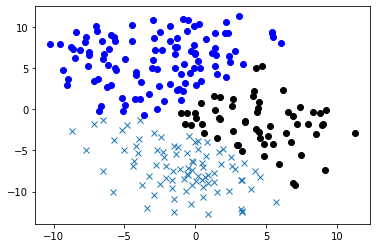

In [35]:
x = xs[0]
labels = cell_data[0]
bint = labels==0
plt.plot(x[bint,0],x[bint,1],'x')
bint = labels==1
plt.plot(x[bint,0],x[bint,1],'bo')
bint = labels==2
plt.plot(x[bint,0],x[bint,1],'ko')
#bint = labels==3
#plt.plot(x[bint,0],x[bint,1],'+')

In [ ]:
plt.plot(x[:,0],x[:,1],'o')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


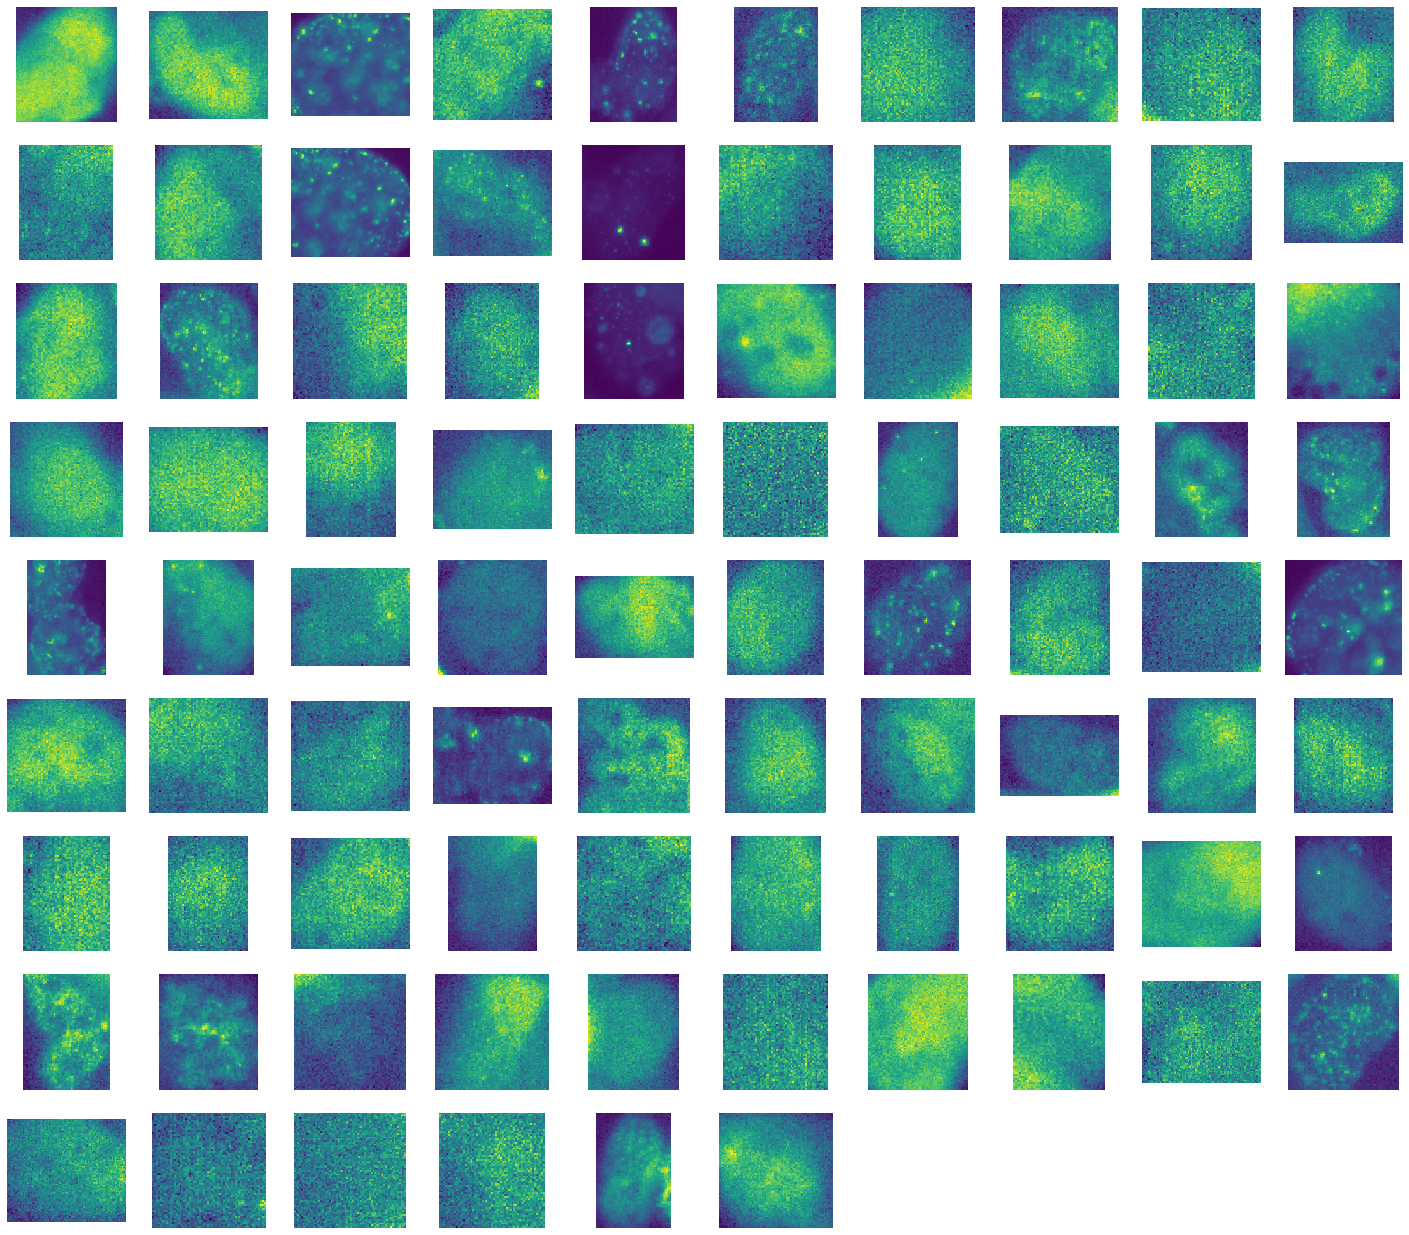

In [36]:
view_cluster(cell_data[0],cell_imgs,0)



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


Clipping cluster size from 107 to 30


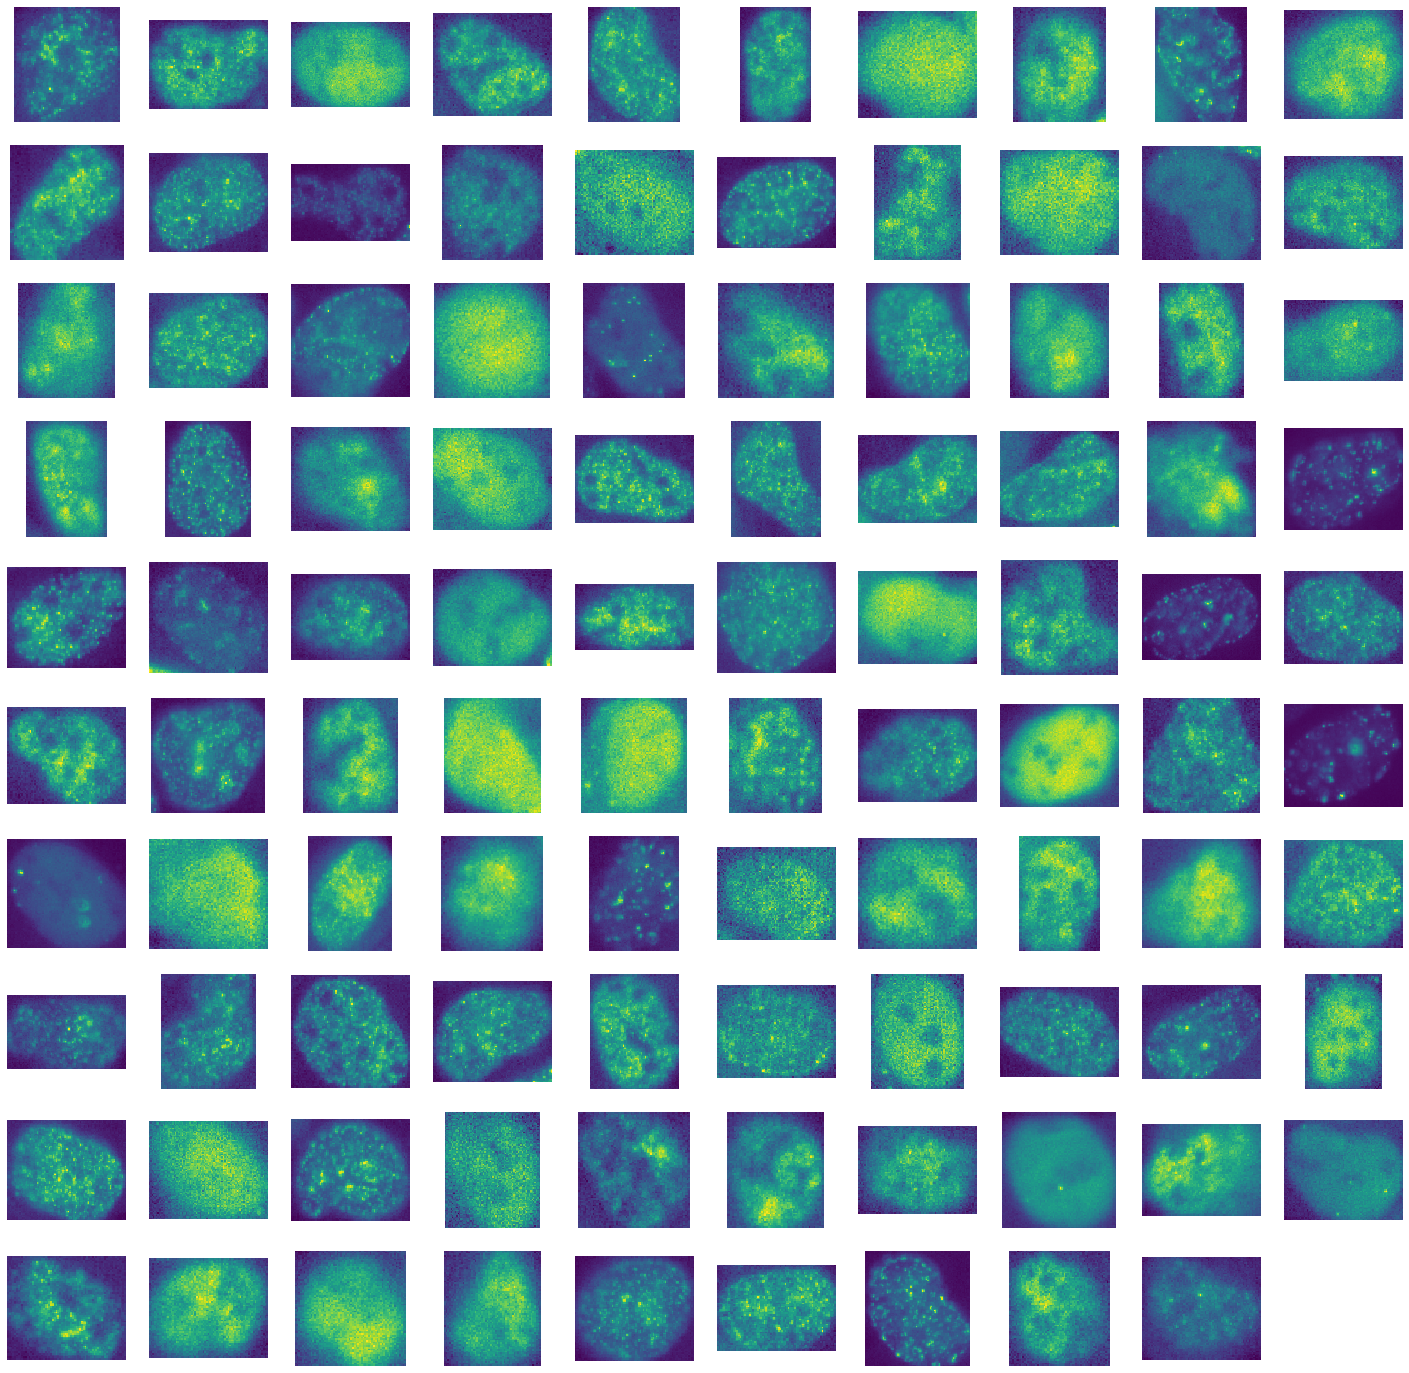

In [37]:
view_cluster(cell_data[0],cell_imgs,1)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


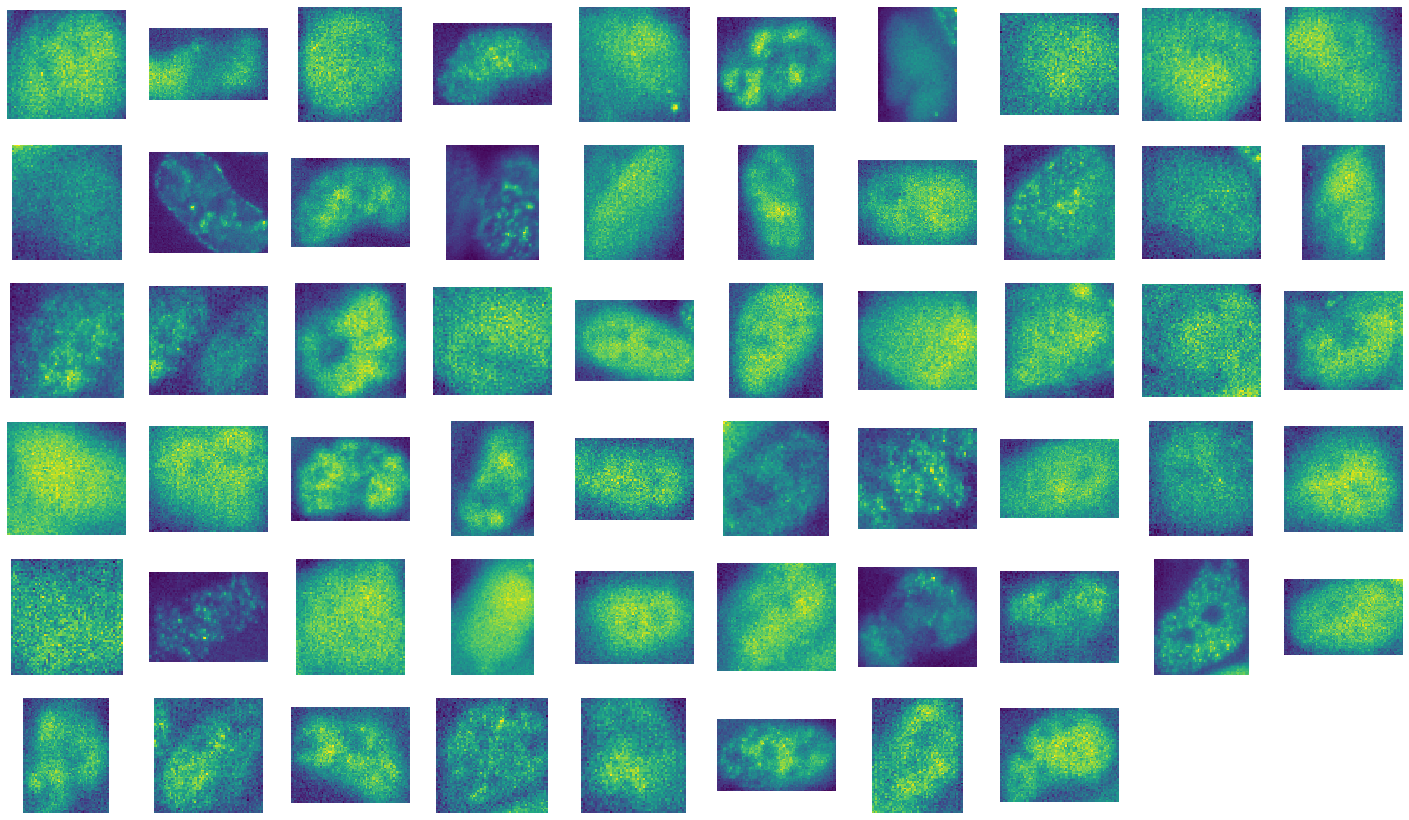

In [38]:
view_cluster(cell_data[0],cell_imgs,2)

In [39]:
view_cluster(cell_data[0],cell_imgs,3)
#view_cluster(cell_data[0],cell_imgs,3)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


<Figure size 1800x1800 with 0 Axes>

In [30]:
store_cell_feats[0].__len__()

9216

In [ ]:
feats